# Basic Strategy

Average Win Rate: 42.20%
Total Earnings: $-8042.00


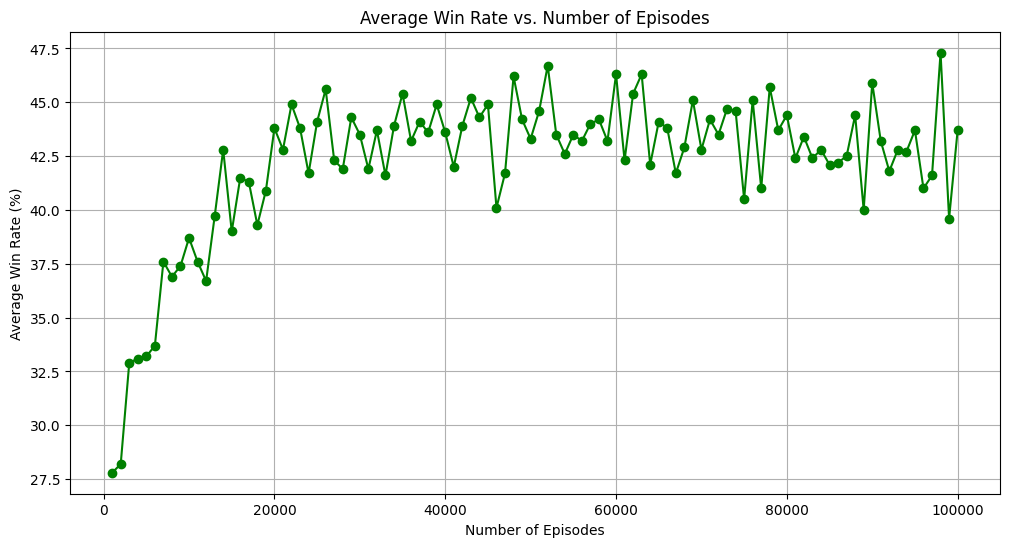

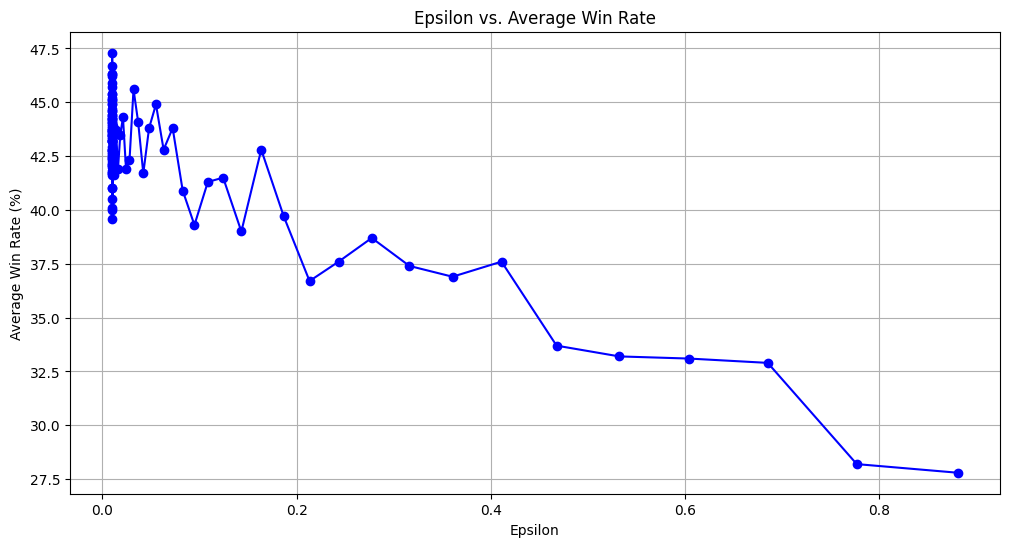

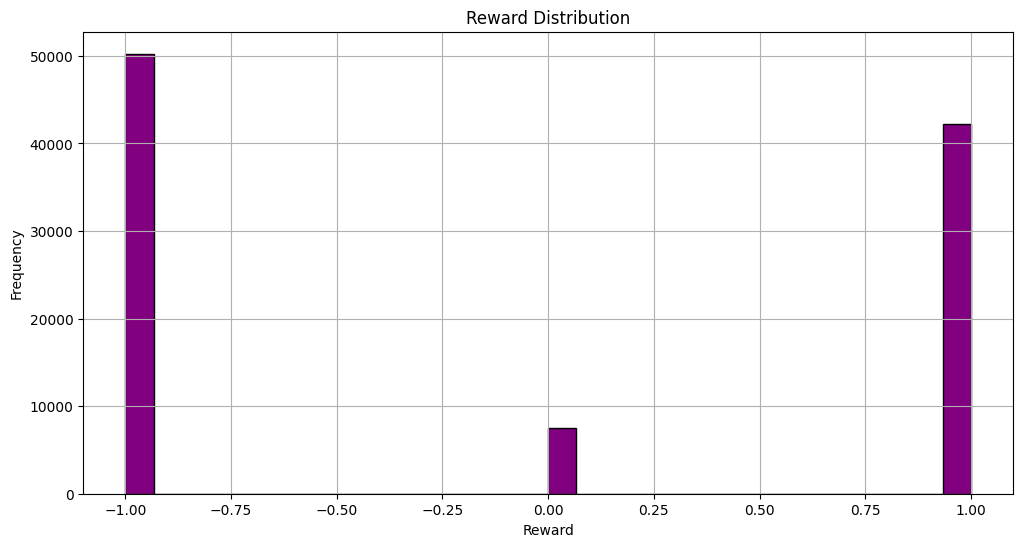

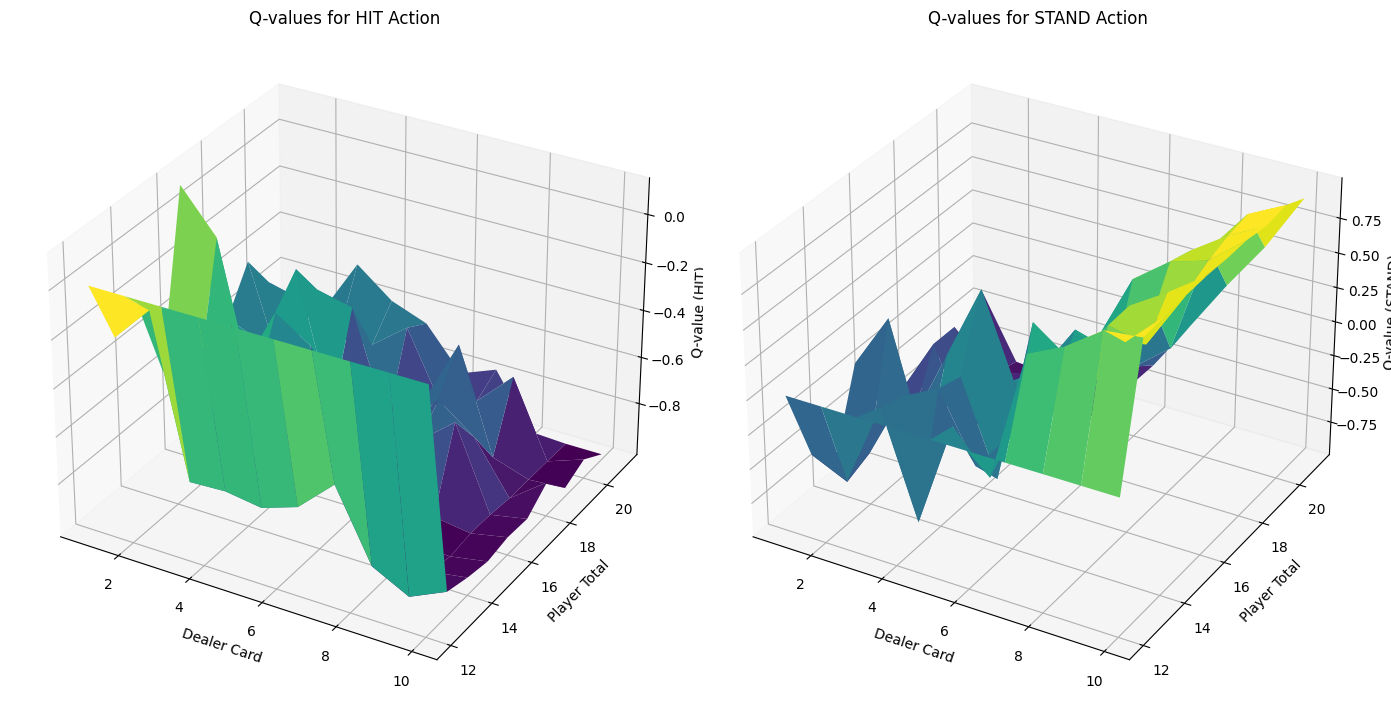

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Environment parameters and the blackjack game information
ACTION_HIT = 0
ACTION_STAND = 1
ACTIONS = [ACTION_HIT, ACTION_STAND]
TOTAL_EPISODES = 100000
INITIAL_EPSILON = 1.0
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 1.0
MIN_EPSILON_VALUE = 0.01
EPSILON_DECREASE_RATE = 0.9999
REPORT_INTERVAL = 1000

class Blackjack:
    def __init__(self):
        self.initialize_game()

    def initialize_game(self):
        self.player_cards = self.deal_hand()
        self.dealer_cards = self.deal_hand()
        self.is_done = False
        self.has_usable_ace_player = self.contains_usable_ace(self.player_cards)
        return self.state()

    def draw_card(self):
        return random.choice([2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11])

    def deal_hand(self):
        return [self.draw_card(), self.draw_card()]

    def hand_value(self, hand):
        total = sum(hand)
        if 11 in hand and total + 10 <= 21:
            return total + 10, True
        return total, False

    def is_over(self, hand):
        return self.hand_value(hand)[0] > 21

    def contains_usable_ace(self, hand):
        return 11 in hand and sum(hand) + 10 <= 21

    def state(self):
        player_total, _ = self.hand_value(self.player_cards)
        return (player_total, self.dealer_cards[0], self.has_usable_ace_player)

    def dealer_play(self):
        while self.hand_value(self.dealer_cards)[0] < 17:
            self.dealer_cards.append(self.draw_card())

    def result(self, player_total, dealer_total):
        if dealer_total > 21 or player_total > dealer_total:
            return 1
        elif dealer_total > player_total:
            return -1
        else:
            return 0

    def step(self, action):
        if self.is_done:
            raise ValueError("Episode ended. Call initialize_game() to start a new episode.")

        if action == ACTION_HIT:
            self.player_cards.append(self.draw_card())
            self.has_usable_ace_player = self.contains_usable_ace(self.player_cards)
            if self.is_over(self.player_cards):
                self.is_done = True
                reward = -1
            else:
                reward = 0
        elif action == ACTION_STAND:
            self.is_done = True
            self.dealer_play()
            dealer_total, _ = self.hand_value(self.dealer_cards)
            player_total, _ = self.hand_value(self.player_cards)
            reward = self.result(player_total, dealer_total)

        return self.state(), reward, self.is_done

class QLearningAgent:
    def __init__(self, actions, alpha, gamma, epsilon, epsilon_decay, min_epsilon):
        self.actions = actions
        self.learning_rate = alpha
        self.discount_factor = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.Q_table = {}

    def get_Q_value(self, state, action):
        if state not in self.Q_table:
            self.Q_table[state] = np.zeros(len(self.actions))
        return self.Q_table[state][action]

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.actions)
        else:
            Q_values = [self.get_Q_value(state, action) for action in self.actions]
            return np.argmax(Q_values)

    def update_Q_table(self, state, action, reward, next_state, done):
        current_Q = self.get_Q_value(state, action)
        max_next_Q = max([self.get_Q_value(next_state, a) for a in self.actions])
        target_Q = reward + self.discount_factor * max_next_Q * (1 - done)
        self.Q_table[state][action] += self.learning_rate * (target_Q - current_Q)
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

def run_training(agent, environment, episodes, interval):
    reward_list = []
    win_percentage_list = []
    epsilon_values_list = []
    profit_list = []
    win_count = 0

    for episode in range(episodes):
        current_state = environment.initialize_game()
        total_reward = 0
        done = False
        while not done:
            action = agent.select_action(current_state)
            next_state, reward, done = environment.step(action)
            agent.update_Q_table(current_state, action, reward, next_state, done)
            current_state = next_state
            total_reward += reward
        reward_list.append(total_reward)
        profit_list.append(total_reward)
        if total_reward > 0:
            win_count += 1

        if (episode + 1) % interval == 0:
            win_rate = win_count / interval
            win_percentage_list.append(win_rate)
            epsilon_values_list.append(agent.epsilon)
            win_count = 0

    return reward_list, win_percentage_list, epsilon_values_list, profit_list

def visualize_Q_values(Q_table, actions):
    player_total_range = range(12, 22)
    dealer_card_range = range(1, 11)
    ace_status = [0, 1]

    player_total_grid, dealer_card_grid, ace_status_grid = np.meshgrid(player_total_range, dealer_card_range, ace_status, indexing='ij')
    Q_hit_values = np.zeros(player_total_grid.shape)
    Q_stand_values = np.zeros(player_total_grid.shape)

    for player_total in player_total_range:
        for dealer_card in dealer_card_range:
            for ace in ace_status:
                state = (player_total, dealer_card, ace)
                if state in Q_table:
                    Q_hit_values[player_total - 12, dealer_card - 1, ace] = Q_table[state][ACTION_HIT]
                    Q_stand_values[player_total - 12, dealer_card - 1, ace] = Q_table[state][ACTION_STAND]

    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(121, projection='3d')
    x, y = np.meshgrid(dealer_card_range, player_total_range)
    ax.plot_surface(x, y, Q_hit_values[:, :, 0].T, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Dealer Card')
    ax.set_ylabel('Player Total')
    ax.set_zlabel('Q-value (HIT)')
    ax.set_title('Q-values for HIT Action')

    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(x, y, Q_stand_values[:, :, 0].T, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Dealer Card')
    ax.set_ylabel('Player Total')
    ax.set_zlabel('Q-value (STAND)')
    ax.set_title('Q-values for STAND Action')

    plt.tight_layout()
    plt.show()

game = Blackjack()
agent = QLearningAgent(actions=ACTIONS, alpha=LEARNING_RATE, gamma=DISCOUNT_FACTOR, epsilon=INITIAL_EPSILON, epsilon_decay=EPSILON_DECREASE_RATE, min_epsilon=MIN_EPSILON_VALUE)
rewards, win_rates, epsilon_vals, profits = run_training(agent, game, TOTAL_EPISODES, REPORT_INTERVAL)

average_win_rate = np.mean(win_rates) * 100
total_earnings = np.sum(profits)

print(f"Average Win Rate: {average_win_rate:.2f}%")
print(f"Total Earnings: ${total_earnings:.2f}")

episode_numbers = np.arange(REPORT_INTERVAL, TOTAL_EPISODES + 1, REPORT_INTERVAL)
plt.figure(figsize=(12, 6))
plt.plot(episode_numbers, np.array(win_rates) * 100, marker='o', linestyle='-', color='green')
plt.xlabel('Number of Episodes')
plt.ylabel('Average Win Rate (%)')
plt.title('Average Win Rate vs. Number of Episodes')
plt.grid(True)
plt.show()

epsilon_vs_win_rate = [(epsilon, win_rate * 100) for epsilon, win_rate in zip(epsilon_vals, win_rates)]
epsilons, win_rates_percentage = zip(*epsilon_vs_win_rate)

plt.figure(figsize=(12, 6))
plt.plot(epsilons, win_rates_percentage, marker='o', linestyle='-', color='blue')
plt.xlabel('Epsilon')
plt.ylabel('Average Win Rate (%)')
plt.title('Epsilon vs. Average Win Rate')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.hist(rewards, bins=30, color='purple', edgecolor='black')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.title('Reward Distribution')
plt.grid(True)
plt.show()

visualize_Q_values(agent.Q_table, ACTIONS)

COMPLETE POINT COUNT SYSTEM

Training finished.
Final Point Count: 3
Average reward over 10000 episodes: -0.09519
Win percentage over 10000 episodes: 40.947%


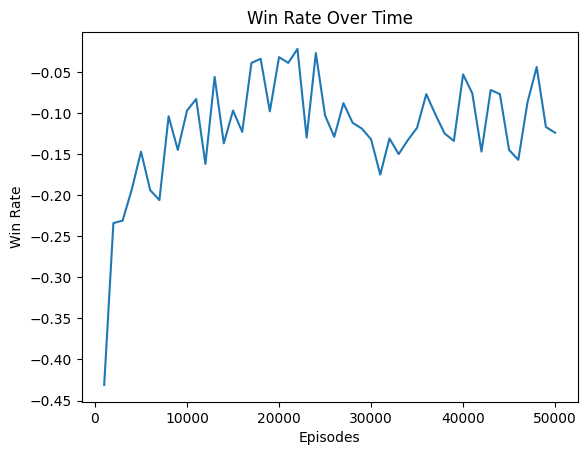

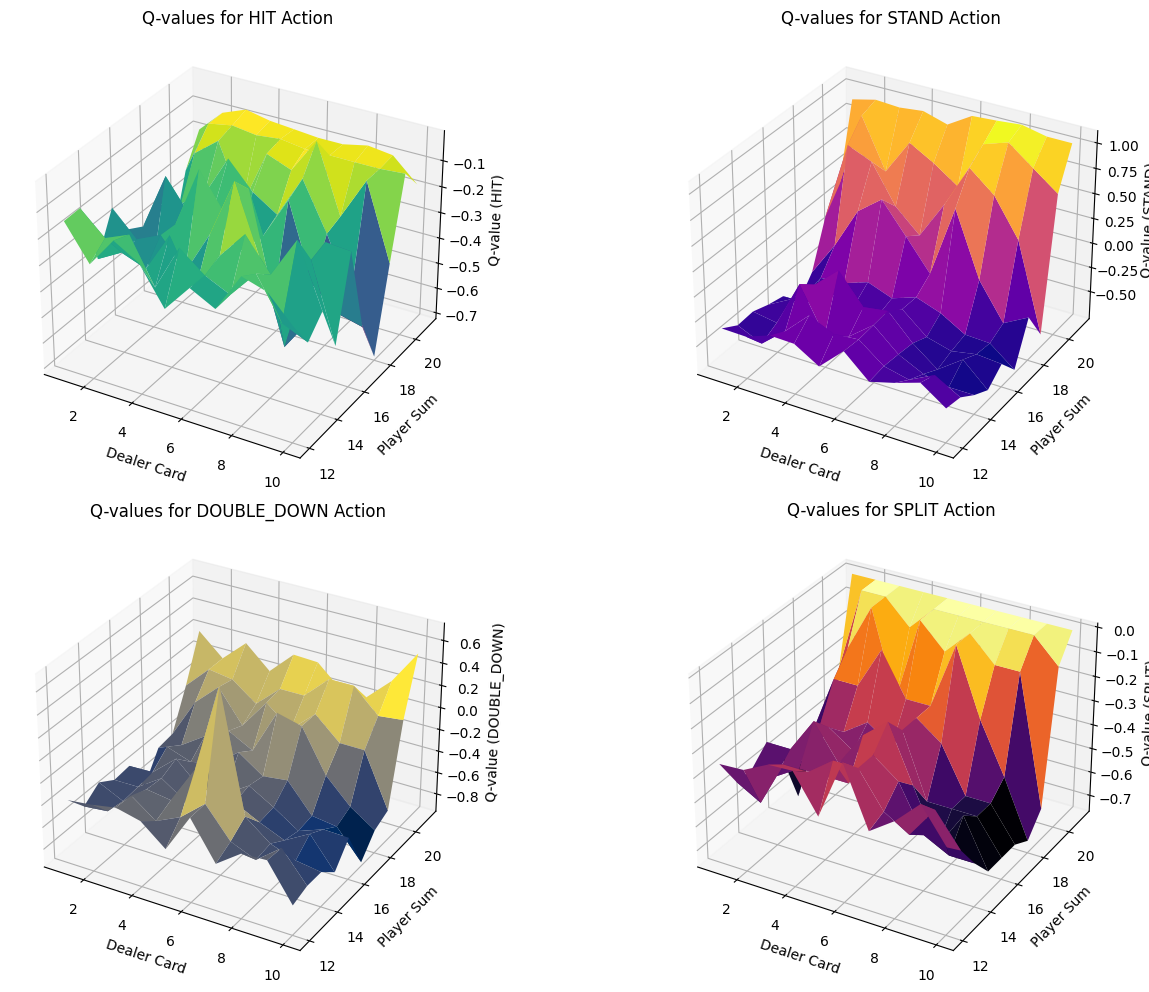

In [ ]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


CARD_VALUES = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
SUITS = ['Hearts', 'Diamonds', 'Clubs', 'Spades']

class PointCountSystem:
    def __init__(self, num_decks=1, count_values=None):
        self.num_decks = num_decks
        self.count_values = count_values if count_values else {
            2: 1, 3: 1, 4: 1, 5: 1, 6: 1,                                       # +1 for low cards
            7: 0, 8: 0, 9: 0,                                                   # 0 for neutral cards
            10: -1, 11: -1, 12: -1, 13: -1, 1: -1                               # -1 for high cards (face cards and ace)
        }
        self.reset_count()

    def update_count(self, card):
        self.count += self.count_values.get(card, 0)

    def reset_count(self):
        self.count = 0

    def get_count(self):
        return self.count

    def get_true_count(self):
        return self.count / self.num_decks

class BlackjackEnv:
    def __init__(self):
        self.point_count_system = PointCountSystem(num_decks=4)
        self.deck = self.create_deck()
        self.reset()

    def create_deck(self):
        return [value for value in CARD_VALUES for _ in SUITS] * 4

    def draw_card(self):
        card = self.deck.pop(random.randint(0, len(self.deck) - 1))
        self.point_count_system.update_count(card)
        return card

    def sum_hand(self, hand):
        total = sum(hand)
        if 1 in hand and total + 10 <= 21:
            return total + 10
        return total

    def is_bust(self, hand):
        return self.sum_hand(hand) > 21

    def dealer_should_hit(self):
        total = self.sum_hand(self.dealer_hand)
        if total < 17:
            return True
        if total == 17 and any(card == 1 for card in self.dealer_hand):
            return True
        return False

    def reset(self):
        self.point_count_system.reset_count()
        self.deck = self.create_deck()
        random.shuffle(self.deck)
        self.player_hand = [self.draw_card(), self.draw_card()]
        self.dealer_hand = [self.draw_card(), self.draw_card()]
        self.double_down_allowed = True
        return self.get_state()

    def step(self, action):
        if action == 'hit':
            self.player_hand.append(self.draw_card())
            if self.is_bust(self.player_hand):
                return self.get_state(), -1, True
            else:
                return self.get_state(), 0, False

        elif action == 'stand':
            while self.dealer_should_hit():
                self.dealer_hand.append(self.draw_card())
            if self.is_bust(self.dealer_hand):
                return self.get_state(), 1, True
            elif self.sum_hand(self.dealer_hand) > self.sum_hand(self.player_hand):
                return self.get_state(), -1, True
            elif self.sum_hand(self.dealer_hand) < self.sum_hand(self.player_hand):
                return self.get_state(), 1, True
            else:
                return self.get_state(), 0, True

        elif action == 'double_down':
            if self.double_down_allowed:
                self.double_down_allowed = False
                self.player_hand.append(self.draw_card())
                if self.is_bust(self.player_hand):
                    return self.get_state(), -2, True
                else:
                    while self.dealer_should_hit():
                        self.dealer_hand.append(self.draw_card())
                    if self.is_bust(self.dealer_hand):
                        return self.get_state(), 2, True
                    elif self.sum_hand(self.dealer_hand) > self.sum_hand(self.player_hand):
                        return self.get_state(), -2, True
                    elif self.sum_hand(self.dealer_hand) < self.sum_hand(self.player_hand):
                        return self.get_state(), 2, True
                    else:
                        return self.get_state(), 0, True
            else:
                raise ValueError("Double Down is only allowed on the initial hand.")

        elif action == 'split':
            if len(self.player_hand) == 2 and self.player_hand[0] == self.player_hand[1]:
                card = self.player_hand.pop()
                hand1 = [card, self.draw_card()]
                hand2 = [card, self.draw_card()]

                total_reward = 0
                hands = [hand1, hand2]

                for hand in hands:
                    while not self.is_bust(hand) and self.sum_hand(hand) < 21:
                        next_action = 'stand'
                        if next_action == 'hit':
                            hand.append(self.draw_card())
                        else:
                            while self.dealer_should_hit():
                                self.dealer_hand.append(self.draw_card())
                            if self.is_bust(self.dealer_hand):
                                total_reward += 1
                            elif self.sum_hand(self.dealer_hand) > self.sum_hand(hand):
                                total_reward -= 1
                            elif self.sum_hand(self.dealer_hand) < self.sum_hand(hand):
                                total_reward += 1
                            else:
                                total_reward += 0
                            break
                return self.get_state(), total_reward, True
            else:
                return self.get_state(), -1, True
        else:
            raise ValueError(f"Unknown action: {action}")

    def get_state(self):
        return (self.sum_hand(self.player_hand), self.dealer_hand[0], self.is_ace_in_hand())

    def is_ace_in_hand(self):
        return 1 in self.player_hand

class QLearningAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.1, epsilon=0.01):
        self.q_table = defaultdict(lambda: np.zeros(len(actions)))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.actions = actions

    def choose_action(self, state, env):
        if random.uniform(0, 1) < self.epsilon:
            valid_actions = self.get_valid_actions(state, env)
            return random.choice(valid_actions)
        else:
            return self.actions[np.argmax(self.q_table[state])]

    def get_valid_actions(self, state, env):
        valid_actions = self.actions[:]
        player_sum, dealer_card, ace_in_hand = state
        if len(env.player_hand) != 2 or env.player_hand[0] != env.player_hand[1]:
            valid_actions.remove('split')
        if not env.double_down_allowed:
            valid_actions.remove('double_down')
        return valid_actions

    def learn(self, state, action, reward, next_state):
        action_index = self.actions.index(action)
        q_predict = self.q_table[state][action_index]
        if next_state is not None:
            q_target = reward + self.gamma * np.max(self.q_table[next_state])
        else:
            q_target = reward
        self.q_table[state][action_index] += self.alpha * (q_target - q_predict)

actions = ['hit', 'stand', 'double_down', 'split']
agent = QLearningAgent(actions)
env = BlackjackEnv()

# Training the agent
num_episodes = 50000
rewards = []
win_rates = []
points = 0
interval = 1000

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.choose_action(state, env)
        next_state, reward, done = env.step(action)
        total_reward += reward

        # Updating the the Q-learning agent
        agent.learn(state, action, reward, next_state)
        state = next_state

    rewards.append(total_reward)
    points += total_reward

    if (episode + 1) % interval == 0:
        win_rates.append(points / interval)
        points = 0

print("Training finished.")
print(f"Final Point Count: {env.point_count_system.get_count()}")

# Evaluate the agent
def evaluate_agent(agent, env, num_episodes=1000):
    total_rewards = 0
    wins = 0
    losses = 0
    ties = 0

    for _ in range(num_episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            action = agent.choose_action(state, env)
            next_state, reward, done = env.step(action)
            episode_reward += reward

            state = next_state

        total_rewards += episode_reward
        if episode_reward > 0:
            wins += 1
        elif episode_reward < 0:
            losses += 1
        else:
            ties += 1

    avg_reward = total_rewards / num_episodes
    win_percentage = wins / num_episodes * 100

    return avg_reward, win_percentage

# Evaluating the blackjack agent
average_reward, win_percentage = evaluate_agent(agent, env, num_episodes=100000)
print(f'Average reward over 10000 episodes: {average_reward}')
print(f'Win percentage over 10000 episodes: {win_percentage}%')

# Plot Q-values
def plot_Q_values_3D(Q, actions):
    player_sum_range = range(12, 22)
    dealer_card_range = range(1, 11)
    usable_ace_values = [0, 1]

    player_sum_grid, dealer_card_grid, usable_ace_grid = np.meshgrid(player_sum_range, dealer_card_range, usable_ace_values, indexing='ij')

    Q_values = {action: np.zeros(player_sum_grid.shape) for action in actions}

    for state, q_values in Q.items():
        player_sum, dealer_card, ace_in_hand = state
        if player_sum in player_sum_range and dealer_card in dealer_card_range and ace_in_hand in usable_ace_values:
            for action_index, action in enumerate(actions):
                Q_values[action][player_sum - 12, dealer_card - 1, ace_in_hand] = q_values[action_index]

    fig = plt.figure(figsize=(15, 10))

    # Plot for HIT action
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.plot_surface(dealer_card_grid[:, :, 0], player_sum_grid[:, :, 0], Q_values['hit'][:, :, 0], cmap='viridis')
    ax1.set_xlabel('Dealer Card')
    ax1.set_ylabel('Player Sum')
    ax1.set_zlabel('Q-value (HIT)')
    ax1.set_title('Q-values for HIT Action')

    # Plot for STAND action
    ax2 = fig.add_subplot(222, projection='3d')
    ax2.plot_surface(dealer_card_grid[:, :, 0], player_sum_grid[:, :, 0], Q_values['stand'][:, :, 0], cmap='plasma')
    ax2.set_xlabel('Dealer Card')
    ax2.set_ylabel('Player Sum')
    ax2.set_zlabel('Q-value (STAND)')
    ax2.set_title('Q-values for STAND Action')

    # Plot for DOUBLE_DOWN action
    ax3 = fig.add_subplot(223, projection='3d')
    ax3.plot_surface(dealer_card_grid[:, :, 0], player_sum_grid[:, :, 0], Q_values['double_down'][:, :, 0], cmap='cividis')
    ax3.set_xlabel('Dealer Card')
    ax3.set_ylabel('Player Sum')
    ax3.set_zlabel('Q-value (DOUBLE_DOWN)')
    ax3.set_title('Q-values for DOUBLE_DOWN Action')

    # Plot for SPLIT action
    ax4 = fig.add_subplot(224, projection='3d')
    ax4.plot_surface(dealer_card_grid[:, :, 0], player_sum_grid[:, :, 0], Q_values['split'][:, :, 0], cmap='inferno')
    ax4.set_xlabel('Dealer Card')
    ax4.set_ylabel('Player Sum')
    ax4.set_zlabel('Q-value (SPLIT)')
    ax4.set_title('Q-values for SPLIT Action')

    plt.tight_layout()
    plt.show()

plt.plot(range(interval, num_episodes + 1, interval), win_rates)
plt.xlabel('Episodes')
plt.ylabel('Win Rate')
plt.title('Win Rate Over Time')
plt.show()

plot_Q_values_3D(agent.q_table, actions)
